# Import and Costants

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import imutils
from tqdm.auto import tqdm
from google.colab import drive
from gensim.models import Word2Vec
from collections import Counter
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [2]:
!pip install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 14.7 MB/s 
     |████████████████████████████████| 821 kB 41.0 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.17
    Uninstalling thinc-8.0.17:
      Successfully uninstalled thinc-8.0.17
  Attempting uninstall: spacy
    Found existing installation: spacy 3.3.1
    Uninstalling spacy-3.3.1:
      Successfully uninstalled spacy-3.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.3.0 requires spacy<3.4.0,>=3.3.0.dev0, but you have spacy 3.4.0 which is incompatible.


In [3]:
!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.8 MB 69.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [4]:
import en_core_web_md
nlp = en_core_web_md.load()

# Connection to Google Drive

In [5]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [6]:
%run /content/gdrive/Shareddrives/CyberBullyingClassification/utilities.ipynb

# Dataset loading

In [7]:
train_ds, val_ds, test_ds = load_data_splits()

In [8]:
x_train, y_train, x_val, y_val, x_test, y_test = get_data_and_labels(train_ds, val_ds, test_ds)

# Import pretrained word embedding

The vector representation of words has proven to be effective for this task, made complicated due to the reduced size of the training set. Indeed, we resort to pretrained word embeddings from SpaCy.

In [12]:
vectorizer = TextVectorization(output_mode = 'int', # set different output encoding
                               standardize='lower_and_strip_punctuation',
                               split="whitespace",
                               ngrams=None)
vectorizer.adapt(x_train)

num_tokens = len(vectorizer.get_vocabulary())
num_tokens

33888

In [13]:
MAX_LENGTH = 350 # max len of representation of a tweet
MAX_WORDS = num_tokens # max size of vocabulary

In [ ]:
voc = vectorizer.get_vocabulary()
print(len(voc))
word_index = dict(zip(voc, range(len(voc))))
num_tokens = len(voc)
embedding_dim = 300 #dimensions of embeddings from spacy

27178


In [ ]:
word_index

{'': 0,
 '[UNK]': 1,
 'bulli': 2,
 'school': 3,
 'fuck': 4,
 'like': 5,
 'girl': 6,
 'joke': 7,
 'nigger': 8,
 'high': 9,
 'dumb': 10,
 'muslim': 11,
 'peopl': 12,
 'rape': 13,
 'gay': 14,
 'u': 15,
 'call': 16,
 'rt': 17,
 'one': 18,
 'get': 19,
 'idiot': 20,
 'say': 21,
 'black': 22,
 'make': 23,
 'ass': 24,
 'amp': 25,
 'would': 26,
 'go': 27,
 'islam': 28,
 'think': 29,
 'know': 30,
 'bitch': 31,
 'white': 32,
 'christian': 33,
 'right': 34,
 'mkr': 35,
 'want': 36,
 'use': 37,
 'see': 38,
 'got': 39,
 'time': 40,
 'im': 41,
 'women': 42,
 'dont': 43,
 'support': 44,
 'look': 45,
 'even': 46,
 'woman': 47,
 'hate': 48,
 'shit': 49,
 'ur': 50,
 'never': 51,
 'year': 52,
 'thing': 53,
 'need': 54,
 'terrorist': 55,
 'still': 56,
 'realli': 57,
 'tri': 58,
 'said': 59,
 'first': 60,
 'us': 61,
 'mean': 62,
 'talk': 63,
 'femal': 64,
 'love': 65,
 'kid': 66,
 'kill': 67,
 'friend': 68,
 'man': 69,
 'also': 70,
 'terror': 71,
 'anyth': 72,
 'obama': 73,
 'good': 74,
 'stop': 75,
 'guy':

In [ ]:
hits = 0
misses = 0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
missed_words = []
for word, i in tqdm(word_index.items()):
    embedding_vector = nlp(str(word)).vector
    if np.linalg.norm(embedding_vector)!=0:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV" i.e. Out Of Vocabulary
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        missed_words.append(word)
print()
print("Converted %d words (%d misses)" % (hits, misses))

100%|██████████| 27178/27178 [02:10<00:00, 208.58it/s]


Converted 11670 words (15508 misses)


As we can see there are a lot of missing words, for which we assigned a vector of embedding with all components equal to 0. We will try to understand which words are these.

In [ ]:
missed_words

['',
 'bulli',
 'mkr',
 'realli',
 'femal',
 'radic',
 'someon',
 'funni',
 'everi',
 'middl',
 'countri',
 'everyon',
 'anoth',
 'ignor',
 'rememb',
 'ugli',
 'pretti',
 'sorri',
 'famili',
 'probabl',
 'presid',
 'polic',
 'alreadi',
 'mayb',
 'forc',
 'agre',
 'histori',
 'polit',
 'happi',
 'homophob',
 'cultur',
 'theyr',
 'peac',
 'definit',
 'religi',
 'deserv',
 'andr',
 'jesu',
 'colleg',
 'singl',
 'realiz',
 'apolog',
 'elementari',
 'asshol',
 'entir',
 'exampl',
 'voic',
 'ladi',
 'exactli',
 'crazi',
 'moham',
 'violenc',
 'suicid',
 'innoc',
 'imagin',
 'excus',
 'piec',
 'whatev',
 'clearli',
 'hatr',
 'bodi',
 'sometim',
 'nurs',
 'decid',
 'notsexist',
 'honestli',
 'especi',
 'charact',
 'pussi',
 'nobodi',
 'promot',
 'choic',
 'suppos',
 'becam',
 'horribl',
 'slaveri',
 'anymor',
 'worri',
 'conserv',
 'incid',
 'offens',
 'mkr2015',
 'appar',
 'messag',
 'judg',
 'seriou',
 'societi',
 'accus',
 'practic',
 'femin',
 'everybodi',
 'crimin',
 'popul',
 'outsid',
 

We print the occurences on the train set of the missed words, and we can see how the higher part of the missed words does not reach 5 occurences on the train set.

In [ ]:
corpus = [word for text in x_train for word in text.split()]
count_words = Counter(corpus)
sorted_words = count_words.most_common()

count = 0
for word, occurences in sorted_words:
  if (occurences < 5):
    break
  if (missed_words.count(word) > 0):
    print(word + ": " + str(occurences))
    count += 1
  
print("Number of missed words with more than 5 occurences: " + str(count))

bulli: 7275
mkr: 1393
realli: 924
femal: 850
radic: 763
someon: 674
funni: 641
everi: 629
middl: 615
countri: 567
everyon: 473
anoth: 367
ignor: 344
rememb: 343
ugli: 332
pretti: 299
sorri: 276
famili: 250
probabl: 226
presid: 221
polic: 221
alreadi: 212
mayb: 204
forc: 196
agre: 192
histori: 186
polit: 185
happi: 172
homophob: 171
cultur: 165
theyr: 163
peac: 162
definit: 155
religi: 152
deserv: 151
andr: 151
jesu: 149
colleg: 147
singl: 145
apolog: 142
realiz: 142
elementari: 141
asshol: 139
entir: 136
exampl: 134
ladi: 131
voic: 131
exactli: 129
crazi: 129
moham: 128
violenc: 127
suicid: 125
innoc: 123
excus: 120
imagin: 120
piec: 119
whatev: 118
clearli: 118
hatr: 116
bodi: 115
nurs: 113
decid: 113
sometim: 113
notsexist: 111
especi: 109
honestli: 109
charact: 108
nobodi: 106
pussi: 106
choic: 105
promot: 105
becam: 104
suppos: 104
horribl: 102
slaveri: 100
anymor: 99
conserv: 98
worri: 98
incid: 97
offens: 96
mkr2015: 95
appar: 94
judg: 89
messag: 89
seriou: 88
societi: 87
accus: 

In [ ]:
saveObject(embedding_matrix, EMBEDDINGS_PATH + "/embedding_matrix_spacy")

Saving /content/gdrive/Shareddrives/CyberBullyingClassification/Embeddings/embedding_matrix_spacy.pkl


In [ ]:
embedding_matrix.shape

(27178, 300)

## Custom Word Embedding


In [14]:
vectorizer = TextVectorization(output_mode = 'int', # set different output encoding
                               standardize='lower_and_strip_punctuation',
                               split="whitespace",
                               output_sequence_length = MAX_LENGTH,
                               pad_to_max_tokens=True,
                               max_tokens = MAX_WORDS,
                               ngrams=None)

In [15]:
x_train

array(['im takes 20 hours download',
       'odd jew muslim hundred years ago made england multicultural country god thick untrue cant argue idiots believes england full bame people 1000s years ago',
       'still login freebsd p', ...,
       'questions ask rationalize rape jokes seriously sincerely asking okay excuse rape jokes beyond admitted used gay slur troll people outrage trash heap fuck dude',
       'idiot muslims thugs quickly figured forced everyone convert',
       'fuck blank tweeting fucking dumb nigger know shoot blanks'],
      dtype=object)

In [16]:
vectorizer.adapt(x_train)

In [17]:
len(vectorizer.get_vocabulary())

33888

In [18]:
x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_val = vectorizer(np.array([[s] for s in x_val])).numpy()

y_train = np.array([[s] for s in y_train])
y_val = np.array([[s] for s in y_val])

In [19]:
x_train_tf = tf.convert_to_tensor(x_train)
x_val_tf = tf.convert_to_tensor(x_val)

y_train_tf = tf.convert_to_tensor(y_train)
y_val_tf = tf.convert_to_tensor(y_val)

In [20]:
print(x_train_tf.shape)
print(x_val_tf.shape)

(25079, 350)
(8360, 350)


In [21]:
from tensorflow.keras.layers import Embedding
embedding_dim = 50 
embedding_layer = Embedding(
    input_dim = MAX_WORDS, 
    output_dim = embedding_dim, 
    embeddings_initializer='uniform',
    embeddings_regularizer=None, 
    activity_regularizer=None,
    embeddings_constraint=None, 
    mask_zero=True,
    input_length=MAX_LENGTH
)

In [22]:
model = keras.Sequential()
model.add(embedding_layer)
model.add(layers.Flatten())
model.add(layers.Dense(len(CLASSES), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 50)           1694400   
                                                                 
 flatten (Flatten)           (None, 17500)             0         
                                                                 
 dense (Dense)               (None, 6)                 105006    
                                                                 
Total params: 1,799,406
Trainable params: 1,799,406
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(x_train_tf, y_train,epochs=50, batch_size=128,validation_data=(x_val_tf, y_val), callbacks=[callback])

Epoch 1/50
196/196 [==============================] - 4s 5ms/step - loss: 1.1089 - acc: 0.6335 - val_loss: 0.5374 - val_acc: 0.8072
Epoch 2/50
196/196 [==============================] - 1s 4ms/step - loss: 0.4211 - acc: 0.8312 - val_loss: 0.3876 - val_acc: 0.8325
Epoch 3/50
196/196 [==============================] - 1s 4ms/step - loss: 0.3301 - acc: 0.8701 - val_loss: 0.3641 - val_acc: 0.8495
Epoch 4/50
196/196 [==============================] - 1s 4ms/step - loss: 0.2809 - acc: 0.8990 - val_loss: 0.3503 - val_acc: 0.8575
Epoch 5/50
196/196 [==============================] - 1s 4ms/step - loss: 0.2408 - acc: 0.9165 - val_loss: 0.3550 - val_acc: 0.8571
Epoch 6/50
196/196 [==============================] - 1s 4ms/step - loss: 0.2085 - acc: 0.9289 - val_loss: 0.3541 - val_acc: 0.8602
Epoch 7/50
196/196 [==============================] - 1s 4ms/step - loss: 0.1800 - acc: 0.9403 - val_loss: 0.3606 - val_acc: 0.8586
Epoch 8/50
196/196 [==============================] - 1s 4ms/step - loss: 0.

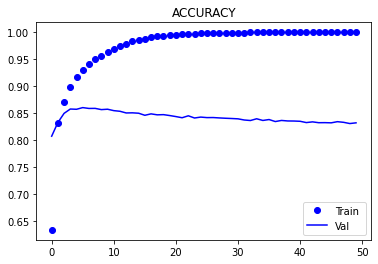

In [25]:
plt.title('ACCURACY')
plt.plot(history.history['acc'],'bo',label = 'Train ')
plt.plot(history.history['val_acc'],'b-',label = 'Val')
plt.legend()
plt.show()

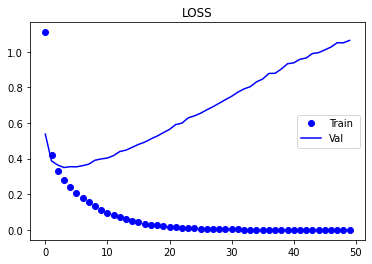

In [26]:
plt.title('LOSS')
plt.plot(history.history['loss'],'bo',label = 'Train ')
plt.plot(history.history['val_loss'],'b-',label = 'Val')
plt.legend()
plt.show()

In [28]:
saveObject(model.layers[0].get_weights()[0], EMBEDDINGS_PATH + "/embedding_matrix_customed")

Saving /content/gdrive/Shareddrives/CyberBullyingClassification/Embeddings/embedding_matrix_customed.pkl
